In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import torch
import pathlib
from torchvision.transforms import ToTensor
from torch import nn
from torch.nn import Sequential
from torch.optim import SGD
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import splitfolders 
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import itertools
import plotly.express as px
from torchvision import models


In [ ]:
output_dir = "/content/drive/MyDrive/dataset"

In [ ]:
import os
import random
import shutil

train_ratio = 0.7
valid_ratio = 0.1
test_ratio = 0.2

# Crear directorios de salida
train_dir = os.path.join(output_dir, "train")
valid_dir = os.path.join(output_dir, "valid")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [ ]:
## Train
train_Images = glob.glob(train_dir + '/*/*.jpeg')
print("Train number of images", len(train_Images))
train_Images = pd.Series(train_Images)
traindf = pd.DataFrame()
traindf['FileName'] = train_Images.map(lambda ImageName :ImageName.split("H")[-1])
traindf['ClassId'] = train_Images.map(lambda ImageName :ImageName.split("/")[-2])
print(traindf['ClassId'].value_counts())

## Val 
val_Images = glob.glob(valid_dir +'/*/*.jpeg')
print("\nValid number of images", len(val_Images))
val_Images = pd.Series(val_Images)
valdf = pd.DataFrame()
valdf['FileName'] = val_Images.map(lambda ImageName :ImageName.split("H")[-1])
valdf['ClassId'] = val_Images.map(lambda ImageName :ImageName.split("/")[-2])
print(valdf['ClassId'].value_counts())
#
##test
test_Images = glob.glob(test_dir + '/*/*.jpeg')
print("\nTest number of images", len(test_Images))
test_Images = pd.Series(test_Images)
testdf = pd.DataFrame()
testdf['FileName'] = test_Images.map(lambda ImageName :ImageName.split("H")[-1])
testdf['ClassId'] = test_Images.map(lambda ImageName :ImageName.split("/")[-2])
print(testdf['ClassId'].value_counts())

Train number of images 16957
perro       3404
araña      3152
gallina     2168
caballo     1844
vaca        1306
ardilla     1303
mariposa    1162
oveja       1008
gato         861
elefante     749
Name: ClassId, dtype: int64

Valid number of images 2417
perro       486
araña      451
gallina     309
caballo     262
ardilla     186
vaca        186
mariposa    153
oveja       149
gato        123
elefante    112
Name: ClassId, dtype: int64

Test number of images 4855
perro       981
araña      894
gallina     621
caballo     525
vaca        374
ardilla     373
mariposa    339
oveja       287
gato        243
elefante    218
Name: ClassId, dtype: int64


In [ ]:
import torch
from torchvision import transforms, datasets

# Definir transformaciones de datos
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=test_transform)

# Crear dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [ ]:

import torch.optim as optim
from torchsummary import summary

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.4)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.4)
        self.conv5 = nn.Conv2d(64, 256, kernel_size=4)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout3 = nn.Dropout(0.4)
        self.fc = nn.Linear(256, 10)  # Cambiar de 64 a 10 unidades
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.dropout1(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.batchnorm4(x)
        x = self.dropout2(x)
        x = nn.functional.relu(self.conv5(x))
        x = self.batchnorm5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout3(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

# Definir el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel()
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mostrar un resumen del modelo
summary(model, (3, 224, 224))  # Dimensiones de entrada: (canal, altura, anchura)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 32, 224, 224]           9,248
       BatchNorm2d-4         [-1, 32, 224, 224]              64
            Conv2d-5         [-1, 32, 112, 112]          25,632
       BatchNorm2d-6         [-1, 32, 112, 112]              64
           Dropout-7         [-1, 32, 112, 112]               0
            Conv2d-8           [-1, 64, 56, 56]          51,264
       BatchNorm2d-9           [-1, 64, 56, 56]             128
          Dropout-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 53, 53]         262,400
      BatchNorm2d-12          [-1, 256, 53, 53]             512
AdaptiveAvgPool2d-13            [-1, 256, 1, 1]               0
          Flatten-14                  [

In [ ]:

train_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Entrenamiento del modelo
num_epochs = 100
best_accuracy = 0.0
patience = 5
counter = 0
best_model_path = output_dir + "/best_custom.pt"


for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento
    running_loss = 0.0
    correct_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Propagación hacia adelante
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Retropropagación y optimización
        loss.backward()
        optimizer.step()

        # Calcular la pérdida y precisión promedio
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

    # Calcular la pérdida y precisión promedio por epoch
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct_predictions / len(train_dataset)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluación en el conjunto de validación
    model.eval()  # Modo de evaluación
    val_correct_predictions = 0

    with torch.no_grad():
        for val_images, val_labels in valid_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()

    val_accuracy = val_correct_predictions / len(valid_dataset)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Accuracy: {epoch_accuracy:.4f} - Validation Accuracy: {val_accuracy:.4f}")


    # Verificación del early stopping y guardado del mejor modelo
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("model saved")
    else:
        counter += 1
        
    if counter >= patience:
        print("Early stopping triggered")
        break



Epoch 1/100 - Train Loss: 2.0601 - Train Accuracy: 0.3994 - Validation Accuracy: 0.4147
model saved
Epoch 2/100 - Train Loss: 2.0508 - Train Accuracy: 0.4075 - Validation Accuracy: 0.4484
model saved
Epoch 3/100 - Train Loss: 2.0384 - Train Accuracy: 0.4194 - Validation Accuracy: 0.4732
model saved
Epoch 4/100 - Train Loss: 2.0220 - Train Accuracy: 0.4368 - Validation Accuracy: 0.4820
model saved
Epoch 5/100 - Train Loss: 2.0171 - Train Accuracy: 0.4425 - Validation Accuracy: 0.5145
model saved
Epoch 6/100 - Train Loss: 2.0022 - Train Accuracy: 0.4557 - Validation Accuracy: 0.4847
Epoch 7/100 - Train Loss: 1.9950 - Train Accuracy: 0.4660 - Validation Accuracy: 0.4832
Epoch 8/100 - Train Loss: 1.9884 - Train Accuracy: 0.4710 - Validation Accuracy: 0.5482
model saved
Epoch 9/100 - Train Loss: 1.9777 - Train Accuracy: 0.4828 - Validation Accuracy: 0.5360


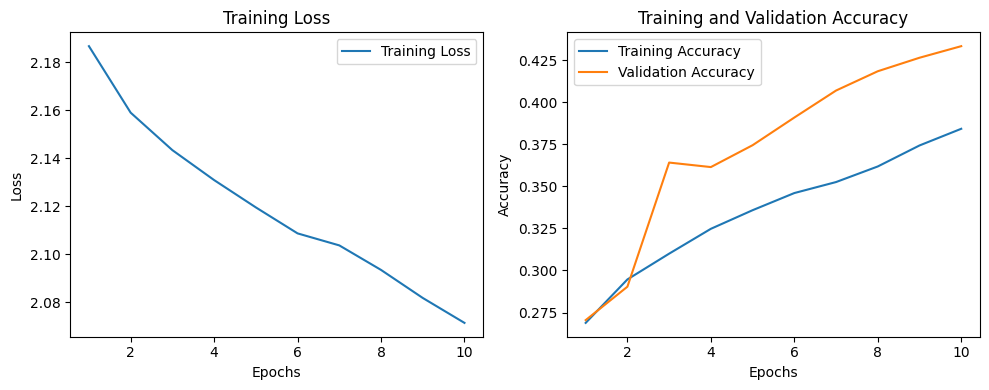

In [ ]:
# Graficar las curvas de pérdida y precisión
epochs = range(1, num_epochs+1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()  # Modo de evaluación
test_correct_predictions = 0
imglabels  = []
imgpredict = []
i=0
with torch.no_grad():
  for test_images, test_labels in test_loader:
    i+=1
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)

    test_outputs = model(test_images)
    _, test_predicted = torch.max(test_outputs.data, 1)
    imglabels.append(test_labels)
    imgpredict.append(test_predicted)
    test_correct_predictions += (test_predicted == test_labels).sum().item()

    test_accuracy = test_correct_predictions / len(test_dataset)

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9819


In [ ]:
flat_labels = []
for tensor in imglabels:
    for item in tensor.flatten():
        flat_labels.append(item.item())

flat_preds = []
for tensor in imgpredict:
    for item in tensor.flatten():
        flat_preds.append(item.item())

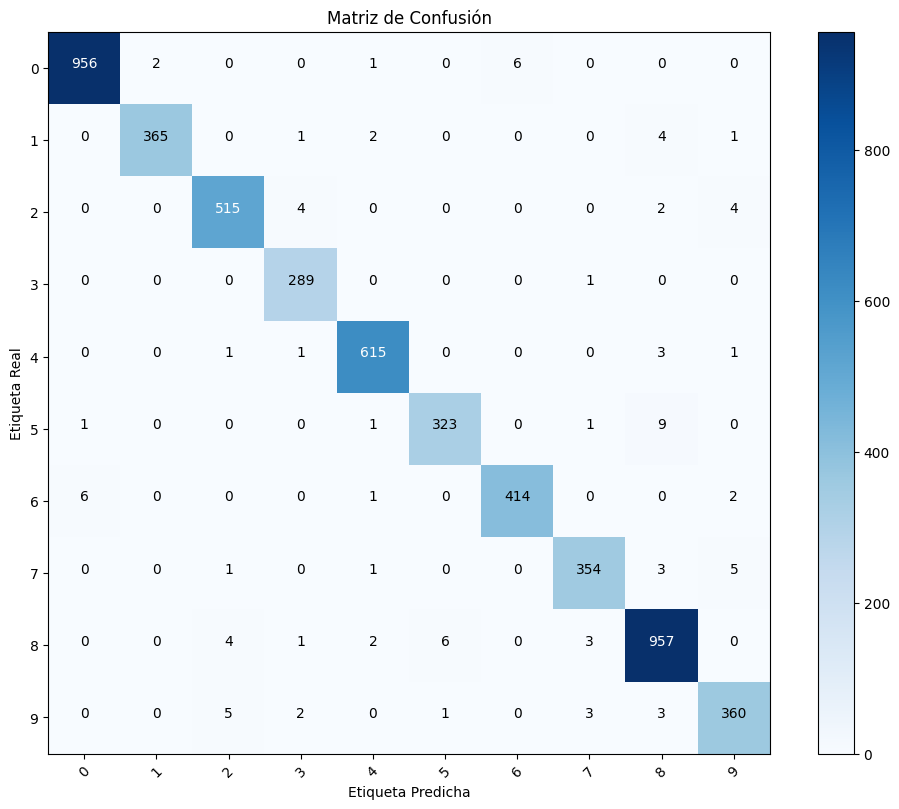

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convertir las listas planas en arrays de NumPy
labels_array = np.array(flat_labels)
preds_array = np.array(flat_preds)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(labels_array, preds_array)

# Obtener las etiquetas únicas
unique_labels = np.unique(labels_array)

# Crear la figura de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, unique_labels, rotation=45)
plt.yticks(tick_marks, unique_labels)

# Rellenar la matriz de confusión con los valores
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


In [ ]:
# Cargar el mejor modelo guardado

best_model_path = "/content/drive/MyDrive/UBA/CV2/TP/best_ResNet50.pt"
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model.load_state_dict(torch.load(best_model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
summary(model, (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,